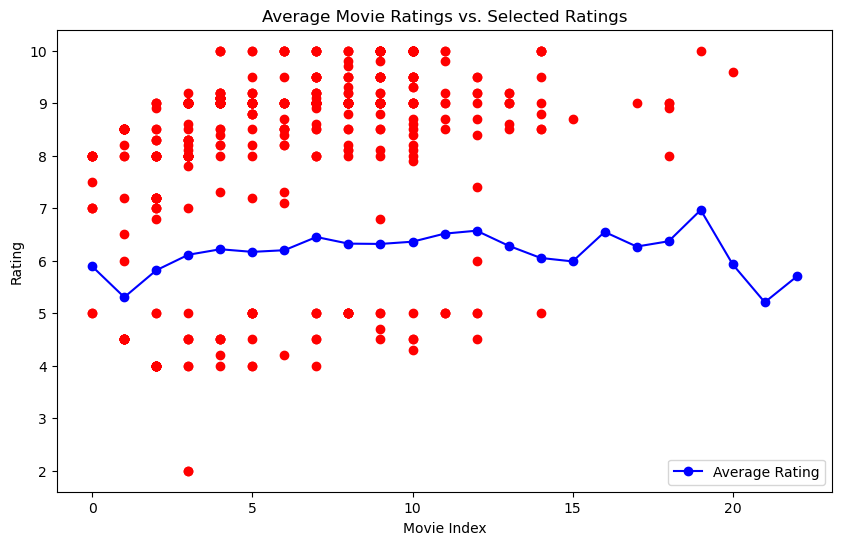

In [31]:
import pandas as pd
import ast
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
#from transformers import pipeline


csv_file = 'sequential_data.csv'


def rating_eval(rating):
    try:
        return float(rating)
    except Exception as e:
        return np.nan

df = pd.read_csv(csv_file, index_col=0,converters={
    'titles': eval,  
    'bin_ratings': eval,  
    'imdb_id': eval,  
    'film_info': eval,  
    'timestamps': eval,  
    'link_clicked': eval,  
    'ids': eval,  
    'avg_ratings': eval,  
    'ratings': eval,  
    'ratings_before_selection': eval, 
    'indices': eval,  
    'Answer.reason_movie': str,
})


df['film_info'] = df['film_info'].apply(lambda x: [ast.literal_eval(i) for i in x])

gpt_df = pd.read_csv('gpt-3.5-synthetic_data_no_user_info.csv', index_col=0, converters={
    'ratings': eval,
    'imdb_id': eval,
    'selected_idx': int,
    'explanations': str,
})
gpt_df['ratings'] = gpt_df['ratings'].apply(lambda x: [rating_eval(i) for i in x])

gpt_df_context = pd.read_csv('gpt-3.5-turbo-user-sim-with-user-info.csv', index_col=0, converters={
    'ratings': eval,
    'imdb_id': eval,
    'selected_idx': int
})
gpt_df_context['ratings'] = gpt_df_context['ratings'].apply(lambda x: [rating_eval(i) for i in x])


film_info = {}
def add_to_film_info(id_list, film_info_list):
    for id, film in zip(id_list, film_info_list):
        film_info[id] = film

avg_ratings = {}
def add_gpt_ratings(imdb_id_list, ratings):
    for id, rating in zip(imdb_id_list, ratings):
        if id in avg_ratings:
            avg_ratings[id][2] = (avg_ratings[id][2]*avg_ratings[id][3] + rating) / (avg_ratings[id][3] + 1)
            avg_ratings[id][3] += 1
        else:
            avg_ratings[id] = [film_info[id]['Title'], film_info[id]['imdbRating'], rating, 1, 'default']

def add_gpt_ratings_context(imdb_id_list, ratings):
    for id, rating in zip(imdb_id_list, ratings):
        if rating == np.nan:
            continue
        if id in avg_ratings:
            if avg_ratings[id][4] == 'default':
                avg_ratings[id][3] = 1
                avg_ratings[id][4] = rating
            else:
                avg_ratings[id][4] = (avg_ratings[id][4]*avg_ratings[id][3] + rating) / (avg_ratings[id][3] + 1)
                avg_ratings[id][3] += 1

df[['imdb_id', 'film_info']].apply(lambda row: add_to_film_info(row['imdb_id'], row['film_info']), axis=1)

gpt_df[['imdb_id', 'ratings']].apply(lambda row: add_gpt_ratings(row['imdb_id'], row['ratings']), axis=1)

gpt_df_context[['imdb_id', 'ratings']].apply(lambda row: add_gpt_ratings_context(row['imdb_id'], row['ratings']), axis=1)


df_ratings = [rating for sublist in df['ratings'] for rating in sublist]

# Extracting ratings for dataset 2
gpt_df_ratings = gpt_df['ratings'].explode().dropna().astype(int).tolist()

gpt_context_ratings = gpt_df_context['ratings'].explode().dropna().astype(int).tolist()

df1_ratings_filtered = [rating for rating in df_ratings if 0 < rating <= 10]
df2_ratings_filtered = [rating for rating in gpt_df_ratings if 0 < rating <= 10]
df3_ratings_filtered = [rating for rating in gpt_context_ratings if 0 < rating <= 10]



combined_df = pd.concat([df, gpt_df, gpt_df_context], axis=0, sort=False)

max_length = max(len(r) for r in combined_df['ratings'])  # Find the maximum sequence length
avg_ratings = [np.nan] * max_length  # Initialize a list to store average ratings

# Calculate the average for each index across all sequences
for i in range(max_length):
    avg_ratings[i] = np.nanmean([r[i] if i < len(r) else np.nan for r in combined_df['ratings']])

#EDA
# Plotting
plt.figure(figsize=(10, 6))

# Plot the average trend line
plt.plot(avg_ratings, marker='o', linestyle='-', color='blue', label='Average Rating')

# Plot the selected ratings
for idx, row in combined_df.iterrows():
    if np.isnan(row['selected_idx']):
        continue
    selected_rating = row['ratings'][int(row['selected_idx'])]
    plt.plot(row['selected_idx'], selected_rating, marker='o', color='red')

plt.xlabel('Movie Index')
plt.ylabel('Rating')
plt.title('Average Movie Ratings vs. Selected Ratings')
plt.legend()
plt.savefig('EDA.pdf')
plt.show()


In [37]:
#Preprocessing for NextItNet

# Convert imdb id to integer
df['imdb_id'] = df['imdb_id'].apply(lambda x: [int(i[2:]) for i in x])

# Assuming movie_ids is a list of your unique movie IDs
movie_ids = list(set(movie_id for ids in df['imdb_id'] for movie_id in ids))

# Create a dictionary that maps each movie ID to a unique index
movie_to_index = {movie_id: index for index, movie_id in enumerate(movie_ids)}

# Transform  movie IDs into indices
df['imdb_id'] = df['imdb_id'].apply(lambda ids: [movie_to_index[id] for id in ids])

In [99]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence  
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from torch import optim


class NextItNet(nn.Module):
    def __init__(self, input_size, output_size, sequence_length, embedding_dim=50, num_filters=100):
        super(NextItNet, self).__init__()

        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rating_embedding = nn.Embedding(11, embedding_dim)  # assuming ratings are from 0 to 9
        self.link_clicked_embedding = nn.Embedding(2, embedding_dim)  # assuming link_clicked is binary

        self.conv1 = nn.Conv1d(embedding_dim * 3, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size=3, padding=1)
        
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x, ratings, link_clicked):
        embedded = self.embedding(x)
        rating_embedded = self.rating_embedding(ratings)
        link_clicked_embedded = self.link_clicked_embedding(link_clicked)

        embedded = torch.cat((embedded, rating_embedded, link_clicked_embedded), 2)
        embedded = embedded.permute(0, 2, 1)  

        out1 = F.relu(self.conv1(embedded))
        out2 = F.relu(self.conv2(out1))
        pooled = F.max_pool1d(out2, out2.size(2)).squeeze(2)
        output = self.fc(pooled)
        return output

class MovieDataset(Dataset):
    def __init__(self, data, input_size, output_size, sequence_length):
        self.data = data
        self.input_size = input_size
        self.output_size = output_size
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data.iloc[idx]['imdb_id'][:self.sequence_length]  
        ratings = self.data.iloc[idx]['ratings'][:self.sequence_length]  
        link_clicked = self.data.iloc[idx]['link_clicked'][:self.sequence_length]  
        target = self.data.iloc[idx]['selcted_idx']  
        return torch.LongTensor(sequence), torch.LongTensor(ratings), torch.LongTensor(link_clicked), torch.LongTensor([target])

def collate_fn(batch):
    sequences, ratings, link_clicked, targets = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    padded_ratings = pad_sequence(ratings, batch_first=True, padding_value=0)
    padded_link_clicked = pad_sequence(link_clicked, batch_first=True, padding_value=0)
    return padded_sequences, padded_ratings, padded_link_clicked, torch.cat(targets)


unique_movie_ids = set(movie_id for ids in df['imdb_id'] for movie_id in ids)
input_size = len(unique_movie_ids)

average_sequence_length = df['len'].mean()

sequence_length = int(0.8 * average_sequence_length)

output_size = len(unique_movie_ids)

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = MovieDataset(train_data, input_size, output_size, sequence_length=sequence_length)  # Adjust sequence_length
test_dataset = MovieDataset(test_data, input_size, output_size, sequence_length=sequence_length)    # Adjust sequence_length

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

model = NextItNet(input_size, output_size, sequence_length=sequence_length, embedding_dim=50, num_filters=100)

num_epochs = 65
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  

for epoch in range(num_epochs):
    for sequences, ratings, link_clicked, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(sequences, ratings, link_clicked)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for sequences, ratings, link_clicked, targets in test_dataloader:
        outputs = model(sequences, ratings, link_clicked)
        
        probabilities = F.softmax(outputs, dim=1)

        _, top_k_predictions = probabilities.topk(k=10, dim=1)

        all_predictions.extend(top_k_predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())


all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate precision at K
correct_predictions = 0
for i in range(len(all_targets)):
    if all_targets[i] in all_predictions[i]:
        correct_predictions += 1

precision_at_k = correct_predictions / len(all_targets)

print(f'Precision at K (K=10): {precision_at_k}')



Precision at K (K=10): 0.8761061946902655


In [468]:
#Preprocessing for SVD, Linear, KNN

df['Genre'] = df['film_info'].apply(lambda x: [i['Genre'].split(', ') for i in x])

In [362]:
#Preprocessing cont.

df['Genre'] = df['film_info'].apply(lambda x: [i['Genre'] for i in x])
def most_common_genre(genres_list):
    return max(set(genres_list), key=genres_list.count)
df['most_common_genre'] = df['Genre'].apply(most_common_genre)
df['Genre'] = df['film_info'].apply(lambda x: [i['Genre'] for i in x])


In [100]:
import pandas as pd

train_data = []
test_data = []

# Identify columns that contain list-type data
list_columns = [col for col in df.columns if isinstance(df[col].iloc[0], list)]
non_list_columns = [col for col in df.columns if col not in list_columns]

for index, row in df.iterrows():
    num_items = len(row[list_columns[0]])

    # Combine list-type columns into a list of dictionaries
    combined = [dict(zip(list_columns, [row[col][i] for col in list_columns])) for i in range(num_items)]

    # Add non-list data to each dictionary
    for item in combined:
        for col in non_list_columns:
            item[col] = row[col]

    # Find the index of the entry with the highest rating
    max_rating_index = max(range(num_items), key=lambda i: row['ratings'][i])

    # Splitting data for each user
    user_train = {col: [row[col][i] for i in range(num_items) if i != max_rating_index] for col in list_columns}
    user_test = {col: [row[col][max_rating_index]] for col in list_columns}

    # For non-list columns, duplicate the value
    for col in non_list_columns:
        user_train[col] = row[col]
        user_test[col] = row[col]

    train_data.append(user_train)
    test_data.append(user_test)

# Convert to DataFrame
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Post-split filtering and checking for movies/users in the training set can be done similarly as before

# Post-split Filtering
train_movies = set()
for titles in train_df['imdb_id']:
    train_movies.update(titles)

# Filter out interactions in the test set with movies not seen in the training set
test_df_filtered = test_df.copy()
test_df_filtered['imdb_id'] = test_df_filtered['imdb_id'].apply(lambda imdb_ids: [imdb_id for imdb_id in imdb_ids if imdb_id in train_movies])

# Aggregate all unique users and movies (titles) in the filtered test set
test_movies_filtered = set()
for titles in test_df_filtered['imdb_id']:
    test_movies_filtered.update(titles)

# Check if all movies in the filtered test set are also in the training set
assert test_movies_filtered.issubset(train_movies), "Filtered test set still contains new movies not in the training set"


In [406]:
#Preprocessing
test_df['Genre'] = test_df['film_info'].apply(lambda x: [i['Genre'] for i in x])
train_df['Genre'] = train_df['film_info'].apply(lambda x: [i['Genre'] for i in x])


In [479]:
#Preprocessing
import pandas as pd

# Assuming your original DataFrame is named df

# Explode the 'es', 'bin_ratings', 'imdb_id', 'ratings', and other relevant columns
exploded_df_test = test_df.explode(['imdb_id', 'ratings']) 

# Filter out rows where 'bin_ratings' is True (assuming this column indicates whether the user rated the movie)

# Create a new DataFrame with the required columns
result_df_test = exploded_df_test[['userId', 'imdb_id', 'ratings']]

# Optional: Convert 'ratings' to numeric if it's stored as strings
result_df_test['ratings'] = pd.to_numeric(result_df_test['ratings'], errors='coerce')

result_df_test


C:\Users\adyme\AppData\Local\Temp\ipykernel_21472\3949947217.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_test['ratings'] = pd.to_numeric(result_df_test['ratings'], errors='coerce')


,userId,imdb_id,ratings
0,FPJLTHLI7K,tt3553442,7
1,U3VNDRDUNB,tt4348012,6
2,8J9OPTZPUD,tt2140423,7
3,Q8D2FPH5AC,tt3899796,8
4,955FMV1WHS,tt1815862,7
...,...,...,...
558,YRP73YFBJS,tt1631867,7
559,K4U4FY85DP,tt1677561,10
560,OCEBYSM45P,tt1677561,8
561,IKDEJIQ11P,tt2404425,9


In [477]:
#Preprocessing
import pandas as pd

# Assuming your original DataFrame is named df

# Explode the 'es', 'bin_ratings', 'imdb_id', 'ratings', and other relevant columns
exploded_df_full = df.explode(['imdb_id', 'ratings'])

# Filter out rows where 'bin_ratings' is True (assuming this column indicates whether the user rated the movie)

# Create a new DataFrame with the required columns
result_df_full = exploded_df_full[['userId', 'imdb_id', 'ratings']]

# Optional: Convert 'ratings' to numeric if it's stored as strings
result_df_full['ratings'] = pd.to_numeric(result_df_full['ratings'], errors='coerce')

result_df_full


C:\Users\adyme\AppData\Local\Temp\ipykernel_21472\730569534.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_full['ratings'] = pd.to_numeric(result_df_full['ratings'], errors='coerce')


,userId,imdb_id,ratings
0,UDOVRK7T7J,tt2379386,2
0,UDOVRK7T7J,tt2381991,5
1,FPJLTHLI7K,tt2828996,1
1,FPJLTHLI7K,tt4009460,1
1,FPJLTHLI7K,tt4877122,2
...,...,...,...
563,Z8C2PY8FD9,tt2014338,7
563,Z8C2PY8FD9,tt3626804,4
563,Z8C2PY8FD9,tt5342766,8
563,Z8C2PY8FD9,tt1091863,7


In [505]:
#Baseline SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# Assuming result_df and result_df_test are your DataFrames
reader = Reader(rating_scale=(1, 10))  # Assuming ratings range from 1 to 10

# Load the dataset from your train DataFrame
trainset = Dataset.load_from_df(result_df[['userId', 'imdb_id', 'ratings']], reader)
trainset = trainset.build_full_trainset()  # Convert to Trainset

testset = Dataset.load_from_df(result_df_test[['userId', 'imdb_id', 'ratings']], reader)
testset = testset.build_full_trainset().build_testset()  # Convert to Testset

# Initialize the SVD model
model = SVD()

# Train the model on the training set
model.fit(trainset)


# Make predictions on the test set
predictions = model.test(testset)

# Evaluate the model's performance
accuracy.rmse(predictions)
accuracy.mae(predictions)


RMSE: 1.8697
MAE:  1.5679


1.567888192859404

In [501]:
#Better SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

reader = Reader(rating_scale=(1, 10)) 

trainset = Dataset.load_from_df(result_df[['userId', 'imdb_id', 'ratings']], reader)
trainset = trainset.build_full_trainset()  

testset = Dataset.load_from_df(result_df_test[['userId', 'imdb_id', 'ratings']], reader)
testset = testset.build_full_trainset().build_testset()  

model = SVD(n_factors=best_params['n_factors'], reg_all=best_params['reg_all'])

model.fit(trainset)

predictions = model.test(testset)

# Evaluate the model's performance
accuracy.rmse(predictions)
accuracy.mae(predictions)


RMSE: 1.4378
MAE:  1.1933


1.1933278744034697

In [481]:
#Baseline KNN
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 10))  # Rating scale
data = Dataset.load_from_df(result_df[['userId', 'imdb_id', 'ratings']], reader)

# Use KNN
knn = KNNBasic()

# Run 5-fold cross-validation 
cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.4732  2.5146  2.5012  2.5158  2.4862  2.4982  0.0165  
MAE (testset)     2.0123  2.0592  2.0234  2.0367  2.0493  2.0362  0.0170  
Fit time          0.02    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.02    0.03    0.03    0.04    0.03    0.03    0.00    


{'test_rmse': array([2.47316871, 2.51458945, 2.50119452, 2.51575411, 2.48621964]),
 'test_mae': array([2.01226694, 2.05918042, 2.02342846, 2.03672429, 2.04932629]),
 'fit_time': (0.01600027084350586,
  0.008646488189697266,
  0.007000446319580078,
  0.010132074356079102,
  0.006979942321777344),
 'test_time': (0.02299809455871582,
  0.03391551971435547,
  0.0346066951751709,
  0.0366671085357666,
  0.030924558639526367)}

In [499]:
#Baseline Linear
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

import ast
import numpy as np

def list_to_avg(lst_str):
    if not lst_str or lst_str == '[]':
        return np.nan
    try:
        # Convert the string representation of list to an actual list
        lst = ast.literal_eval(lst_str)
        numeric_vals = [float(x) for x in lst if isinstance(x, (int, float, str))]
        return np.mean(numeric_vals) if numeric_vals else np.nan
    except (ValueError, SyntaxError):
        return np.nan



# Function to expand rows
def expand_rows(row):
    # Expanding lists into rows
    return pd.DataFrame({
        'title': row['titles'],
        'bin_rating': row['bin_ratings'],
        'imdb_id': row['imdb_id'],
        'procedure': row['procedure'],
        'film_info': row['film_info'],
        'timestamp': row['timestamps'],
        'userId': row['userId'],
        'link_clicked': row['link_clicked'],
        'selected_idx': row['selcted_idx'],
        'avg_rating': row['avg_ratings'],  =
        'ratings': row['ratings'],
        'rating_diff': row['rating_diff'],  
    })


expanded_df = pd.concat(df.apply(expand_rows, axis=1).tolist(), ignore_index=True)

# Select features for the model
features = ['imdb_id', 'userId', 'avg_rating']  

# Preprocessing: Handling categorical data and missing values
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), ['avg_rating']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['imdb_id', 'userId'])
])

# Creating the regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X = expanded_df[features]
y = expanded_df['ratings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)


print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')


Root Mean Squared Error: 2.0162932681979937
Mean Absolute Error: 1.6008416822560045


In [337]:
import numpy as np
import pandas as pd

# Assuming 'result_df' is your DataFrame with 'userId', 'imdb_id', and 'ratings' columns
refined_dataset = result_df.groupby(by=['userId', 'imdb_id'], as_index=False).agg({"ratings": "mean"})

# Creating a list of all users and movies
unique_users = refined_dataset['userId'].unique()
unique_movies = refined_dataset['imdb_id'].unique()
users_dict = {user: i for i, user in enumerate(unique_users)}
movies_dict = {movie: i for i, movie in enumerate(unique_movies)}

# Creating a utility matrix
num_users = len(unique_users)
num_movies = len(unique_movies)
utility_matrix = np.full((num_movies, num_users), np.nan)

for index, row in refined_dataset.iterrows():
    user_idx = users_dict[row['userId']]
    movie_idx = movies_dict[row['imdb_id']]
    utility_matrix[movie_idx, user_idx] = row['ratings']

# Filling missing values using mean imputation
masked_arr = np.ma.masked_array(utility_matrix, np.isnan(utility_matrix))
temp_mask = masked_arr.T
rating_means = np.mean(temp_mask, axis=0)
filled_matrix = temp_mask.filled(rating_means)
filled_matrix = filled_matrix.T

# Normalizing the filled matrix
filled_matrix = filled_matrix - rating_means[:, np.newaxis]
filled_matrix = filled_matrix / np.sqrt(num_movies - 1)

# Computing the SVD of the input matrix
U, S, V = np.linalg.svd(filled_matrix)

# Function to calculate the cosine similarity
def top_cosine_similarity(data, movie_id, top_n=10):
    index = movie_id
    movie_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

# Function to get similar movies
def get_similar_movies(movie_name):
    k = 50
    top_n = 10

    if movie_name not in movies_dict:
        print(f"Movie '{movie_name}' not found in the dataset.")
        return []

    movie_id = movies_dict[movie_name]
    
    if movie_id >= len(unique_movies):
        print(f"Invalid movie index {movie_id}. Check the dataset.")
        return []

    sliced = V.T[:, :k]  # representative data
    indexes = top_cosine_similarity(sliced, movie_id, top_n)
    
    # Ensure that the indexes are within bounds
    valid_indexes = [i for i in indexes[1:] if i < len(unique_movies)]
    
    return [unique_movies[i] for i in valid_indexes]

# Example: Get similar movies for a given movie
similar_movies = get_similar_movies('tt4853102')
print(similar_movies)


['tt2581244', 'tt2278388', 'tt1605782', 'tt2450186', 'tt1336608', 'tt4226388', 'tt5368354']
